In [2]:
!pip install -Iv chaospy==4.3.4
!pip install uncertainpy
!pip install numpy==1.20

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

     |████████████████████████████████| 89 kB 4.7 MB/s 
     |████████████████████████████████| 13.1 MB 21.8 MB/s 
     |████████████████████████████████| 109 kB 66.6 MB/s 
     |████████████████████████████████| 756 kB 69.2 MB/s 
     |████████████████████████████████| 546 kB 54.0 MB/s 
     |████████████████████████████████| 81 kB 8.1 MB/s 
     |████████████████████████████████| 65 kB 2.7 MB/s 
  Created wheel for uncertainpy: filename=uncertainpy-1.2.3-py3-none-any.whl size=108683 sha256=0066416a2a0278b442c48f29ce7cd5645d747567fa11f25914885bcf73059a4f
  Stored in directory: /root/.cache/pip/wheels/6d/cd/85/01dfd83a532d252ac594592b9fbcd86f767bd0658f7988fb42
  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-py3-none-any.whl size=5024 sha256=b5a64a44750adc7c1719906e37839eb398975c5722e76bbf1f273459ca9ab122
  Stored in directory: /root/.cache/pip/wheels/f4/a7/4b/c559bd2437620de067a11d4ab79222445bfe3c4f2130882f76
Successfully built uncertainpy xvfbwrapper
  Attempting uninstall

     |████████████████████████████████| 15.3 MB 8.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [12]:
import uncertainpy as un
import chaospy
import math
import numpy as np
from scipy.stats import gamma, beta
from scipy.optimize import fsolve
from scipy.misc import derivative
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn') 
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 28})
plt.rc('legend', fontsize=12)
plt.rcParams['figure.dpi'] = 300 # Para gerar imagens com maior qualidade

In [13]:
# Same code as for buckley_leverett.py -- needs refactor when chaospy 4.3.4 is available on conda
import math
import numpy as np
from scipy.optimize import fsolve
from scipy.misc import derivative

def kro(kro0, no, sw_min, sw_max, sw):
  s_hat = (sw - sw_min) / (sw_max - sw_min)
  
  # in some cases 1.0 - s_hat ends up being a very small negative number
  delta = np.maximum(0, 1.0 - s_hat)
  ko = kro0 * np.power(delta, no)

  return ko

def krw(krw0, nw, sw_min, sw_max, sw):
  s_hat  = (sw - sw_min)/ (sw_max - sw_min) 
  kw = krw0 * np.power(s_hat, nw)

  return kw


def fractional_flow(mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, sw):
  kr_w = krw(aw, bw, sw_min, sw_max, sw)
  kr_o = kro(ao, bo, sw_min, sw_max, sw)
  
  fw = 1.0 / (1.0 + (kr_o / mu_o) * (mu_w / kr_w))
  
  return fw


def fractional_flow_derivative(mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, sw):
  """
  Calculate the derivative of the fractional flow function using Scipy.
  Wraps the fractional flow function such that the derivative is taken 
  with respect to the eigthth parameter, i.e, the saturation.
  """
  var = 8
  args = [mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, sw]
  def wraps(x):
    args[var] = x
    return fractional_flow(*args)
  return derivative(wraps, args[var], dx = 1e-6)


def flow_profile(sw, *params):
  mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, vd = params

  return fractional_flow_derivative(mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, sw) - vd


def tangent(sw, *params):
  mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max = params
  dfw_dsw = fractional_flow_derivative(mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, sw)
  fw = fractional_flow(mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, sw)
  
  return dfw_dsw - fw / (sw - sw_min)


def buckley_solution(total_time, porosity, diameter, length, injection_rate, mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, output_times):
  def non_dimensional_time(t, q, l, a, phi):
    return (t * q) / (l * a * phi)

  area = math.pi * diameter * diameter / 4.0
  dimensionless_time = non_dimensional_time(total_time, injection_rate, length, area, porosity)
  vd = np.array(np.linspace(0.0, 2 * dimensionless_time, 100))
  sw = np.zeros_like(vd)
  npd = np.zeros_like(vd)
  td = np.linspace(0.0, dimensionless_time, len(npd))
  
  output_tds = []
  for t in output_times:
    if t >= total_time:
      raise ValueError('Output time should not be bigger than the total simualtion time!')
    output_tds.append(non_dimensional_time(t, injection_rate, length, area, porosity))

  # obtain the minimum velocity as a derivative of the fractional flow evaluated at sw_max
  vd_min = fractional_flow_derivative(aw, bw, ao, bo, mu_w, mu_o, sw_min, sw_max, sw_max)

  # now find what is the saturation value at the left of the shock front
  ini_guess = 0.5 * (sw_min + sw_max)
  params = (mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max)
  sw_at_shock_front = fsolve(tangent, ini_guess, args=params)
  
  vd_shock = fractional_flow(mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, sw_at_shock_front) / (sw_at_shock_front - sw_min)

  sw_end_o = sw_at_shock_front
  for i in range(len(vd)):
    # obtain the saturation profile
    if vd[i] <= vd_min:
      sw[i] = sw_max
    elif vd[i] > vd_min and vd[i] <= vd_shock:
      params = (mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, vd[i])
      sw[i] = fsolve(flow_profile, sw[i-1], params)
    else:
      sw[i] = sw_min

    # and also the number of pore volumes produced
    if td[i] < 1.0/vd_shock:
      npd[i] = td[i]
    else:
      params = (mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, 1.0/td[i])
      sw_end = fsolve(flow_profile, sw_end_o, params)
      sw_end_o = sw_end
      fw_end = fractional_flow(mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, sw_end)
      sw_bar = sw_end + td[i] * (1 - fw_end) 
      npd[i] = sw_bar - sw_min

    # rescale the Sw x vd output into Sw x xd for each output_time
    xd = np.linspace(0.0, 1.0, 100)
    out_sw = []
    for t in output_tds:
      x_scale = t * vd
      out_sw.append(np.interp(xd, x_scale, sw))

    # convert td to time in seconds
    out_time = np.linspace(0.0, total_time, 100)
    time = td * length * area * porosity / injection_rate
    out_npd = np.interp(out_time, time, npd)
  
  return out_time, out_npd

In [14]:
# Main input parameters:
aw = 0.2        # coefficient for perm water - max(krw)
bw = 1.5        # water exponent relative permeability
ao = 0.80       # coefficient for perm oil - max(krw)
bo = 2.0         # oil exponent relative permeability
sw_min = 0.1    # min water saturation values
sw_max = 0.9    # max water saturation values
mu_w = 1.0      # water viscosity in centipoise
mu_o = 4.0      # oil viscosity in centipoise

total_simulation_time = 4.0e5  # s
porosity = 0.3  # m3/m3
diameter = 0.036  # m
length = 0.12  # m
injection_rate = 2e-10  # m3/s
output_times = [2.5e4, 5e4, 1e5, 2e5] # seconds

# Define the saturation values in the range stablished
# and compute rel perms and fractional flow (just for visualization).
# Reduce the saturation interval used based on eps to avoid division by zero
# while computing derivatives.
eps = 1.0e-5 
sw = np.linspace(sw_min+eps, sw_max-eps, 100)


In [15]:
number_of_samples = 1000
number_of_bins = round(math.sqrt(number_of_samples))


In [16]:
# Porosity is defined in an interval between zero and one
# so it makes sense to use a beta distribution

# As there is few, if not only one measurement, the nominal value is known but
# no information about variance is known. Check the effect of change in the variance
# as a function of the nominal value: 5%, 10% and 20% of the nominal value

expected_value = 0.3
factors = [5.0, 10.0, 15.0]
samples = []
porosity_distributions = []
uloc = np.linspace(0, 1, number_of_samples)

for f in factors:
  std_dev = (f/100.0) * expected_value
  variance = std_dev * std_dev

  a = expected_value*(expected_value * (1.0 - expected_value)/variance - 1.0)
  b = a * (1.0 - expected_value) / expected_value
  print('a: ', a, 'b: ', b)

  distribution = chaospy.Beta(a, b)
  porosity_distributions.append(distribution)
  samples.append(distribution.sample(number_of_samples))



a:  279.7 b:  652.6333333333333
a:  69.7 b:  162.63333333333333
a:  30.81111111111111 b:  71.89259259259258


In [17]:
# Other properties, such as viscosities, are defined in an interval between zero
# and +infinite so a gamma distribution seems more appropriate (a log-normal could
# also be used)

# Do the same analysis as done for porosity
factors = [5.0, 10.0, 15.0]
expected_value = 1.0
samples = []
water_viscosity_distributions = []
uloc = np.linspace(0, 2, number_of_samples)

for f in factors:
  std_dev = (f/100.0) * expected_value
  variance = std_dev * std_dev

  theta = variance / expected_value
  k = expected_value * expected_value / variance
  distribution = chaospy.Gamma(k, scale = theta)

  water_viscosity_distributions.append(distribution)
  samples.append(distribution.sample(number_of_samples))



In [18]:
expected_value = 4.0
samples = []
oil_viscosity_distributions = []
uloc = np.linspace(2.0, 6.0, number_of_samples)
factors = [2.5, 5.0, 7.5]
for f in factors:
  std_dev = (f/100.0) * expected_value
  variance = std_dev * std_dev

  theta = variance / expected_value
  k = expected_value * expected_value / variance
  distribution = chaospy.Gamma(k, scale = theta)
  print('k: ', k)
  print('theta: ', theta)

  oil_viscosity_distributions.append(distribution)
  samples.append(distribution.sample(number_of_samples))




k:  1599.9999999999998
theta:  0.0025000000000000005
k:  399.99999999999994
theta:  0.010000000000000002
k:  177.77777777777777
theta:  0.0225


In [19]:
def buckley_solution_wrapper(total_time, porosity, diameter, length, injection_rate, mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, output_times):
  """
  A thin wrapper just to get rid of some outputs as by default uncertainpy deals with a single output.
  Need to handle additional outputs later on.
  """
  xd, out_sw, out_time, out_npd = buckley_solution(total_time, porosity, diameter, length, injection_rate, mu_w, mu_o, aw, bw, ao, bo, sw_min, sw_max, output_times)
  return out_time, out_npd


In [20]:
model = un.Model(run=buckley_solution, labels=["time", "Npd"])

In [21]:
# Create the distributions
porosity_dist = porosity_distributions[1]
mu_w_dist = water_viscosity_distributions[1]
mu_o_dist = oil_viscosity_distributions[1]

# Define the parameter dictionary
parameters = {
    "total_time": total_simulation_time,
    "porosity": porosity_dist,
    "diameter": diameter,
    "length": length,
    "injection_rate": injection_rate,
    "mu_w": mu_w_dist,
    "mu_o": mu_o_dist,
    "aw": aw,
    "bw": bw,
    "ao": ao,
    "bo": bo,
    "sw_min": sw_min,
    "sw_max": sw_max,
    "output_times": output_times,
}

# Set up the uncertainty quantification
UQ = un.UncertaintyQuantification(
    model=model,
    parameters=parameters,
)

# Perform the uncertainty quantification using
# polynomial chaos with point collocation (by default)
data = UQ.quantify(  
    nr_pc_mc_samples=1e6,
    polynomial_order=2,
    allow_incomplete=False,
    rosenblatt=False,
    nr_collocation_nodes=1000,
  )

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Running model:  33%|███▎      | 327/1000 [00:34<01:12,  9.34it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
Calculating statistics from PCE: 100%|██████████| 1/1 [00:16<00:00, 16.30s/it]


Saving data as: data/buckley_solution.h5


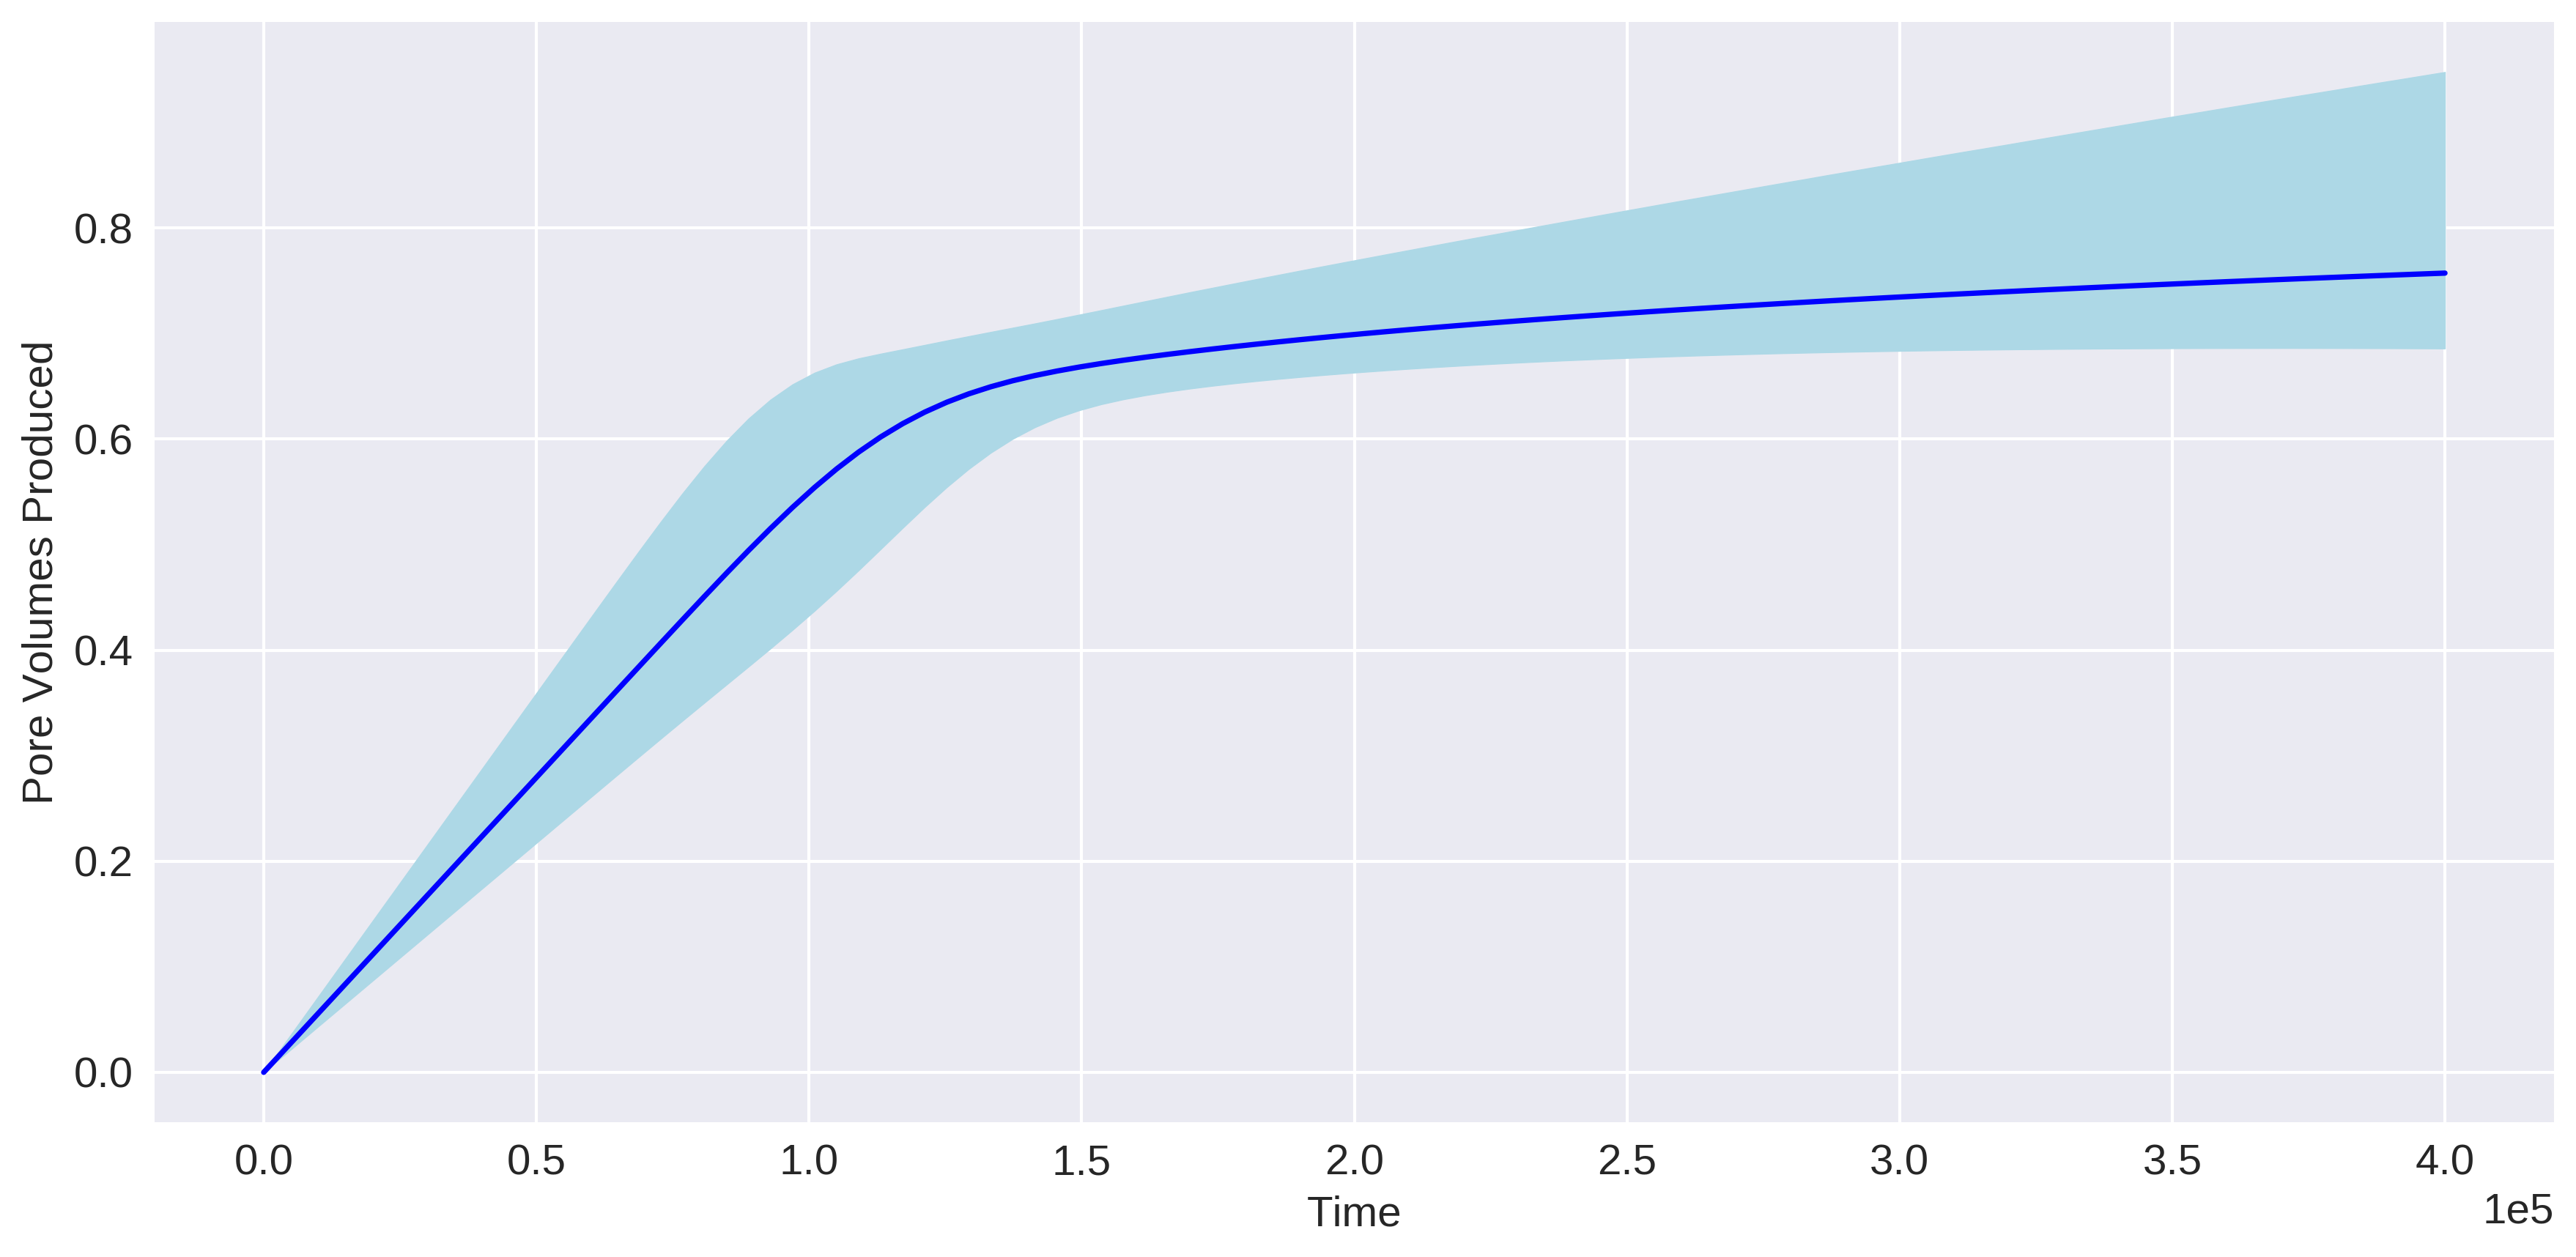

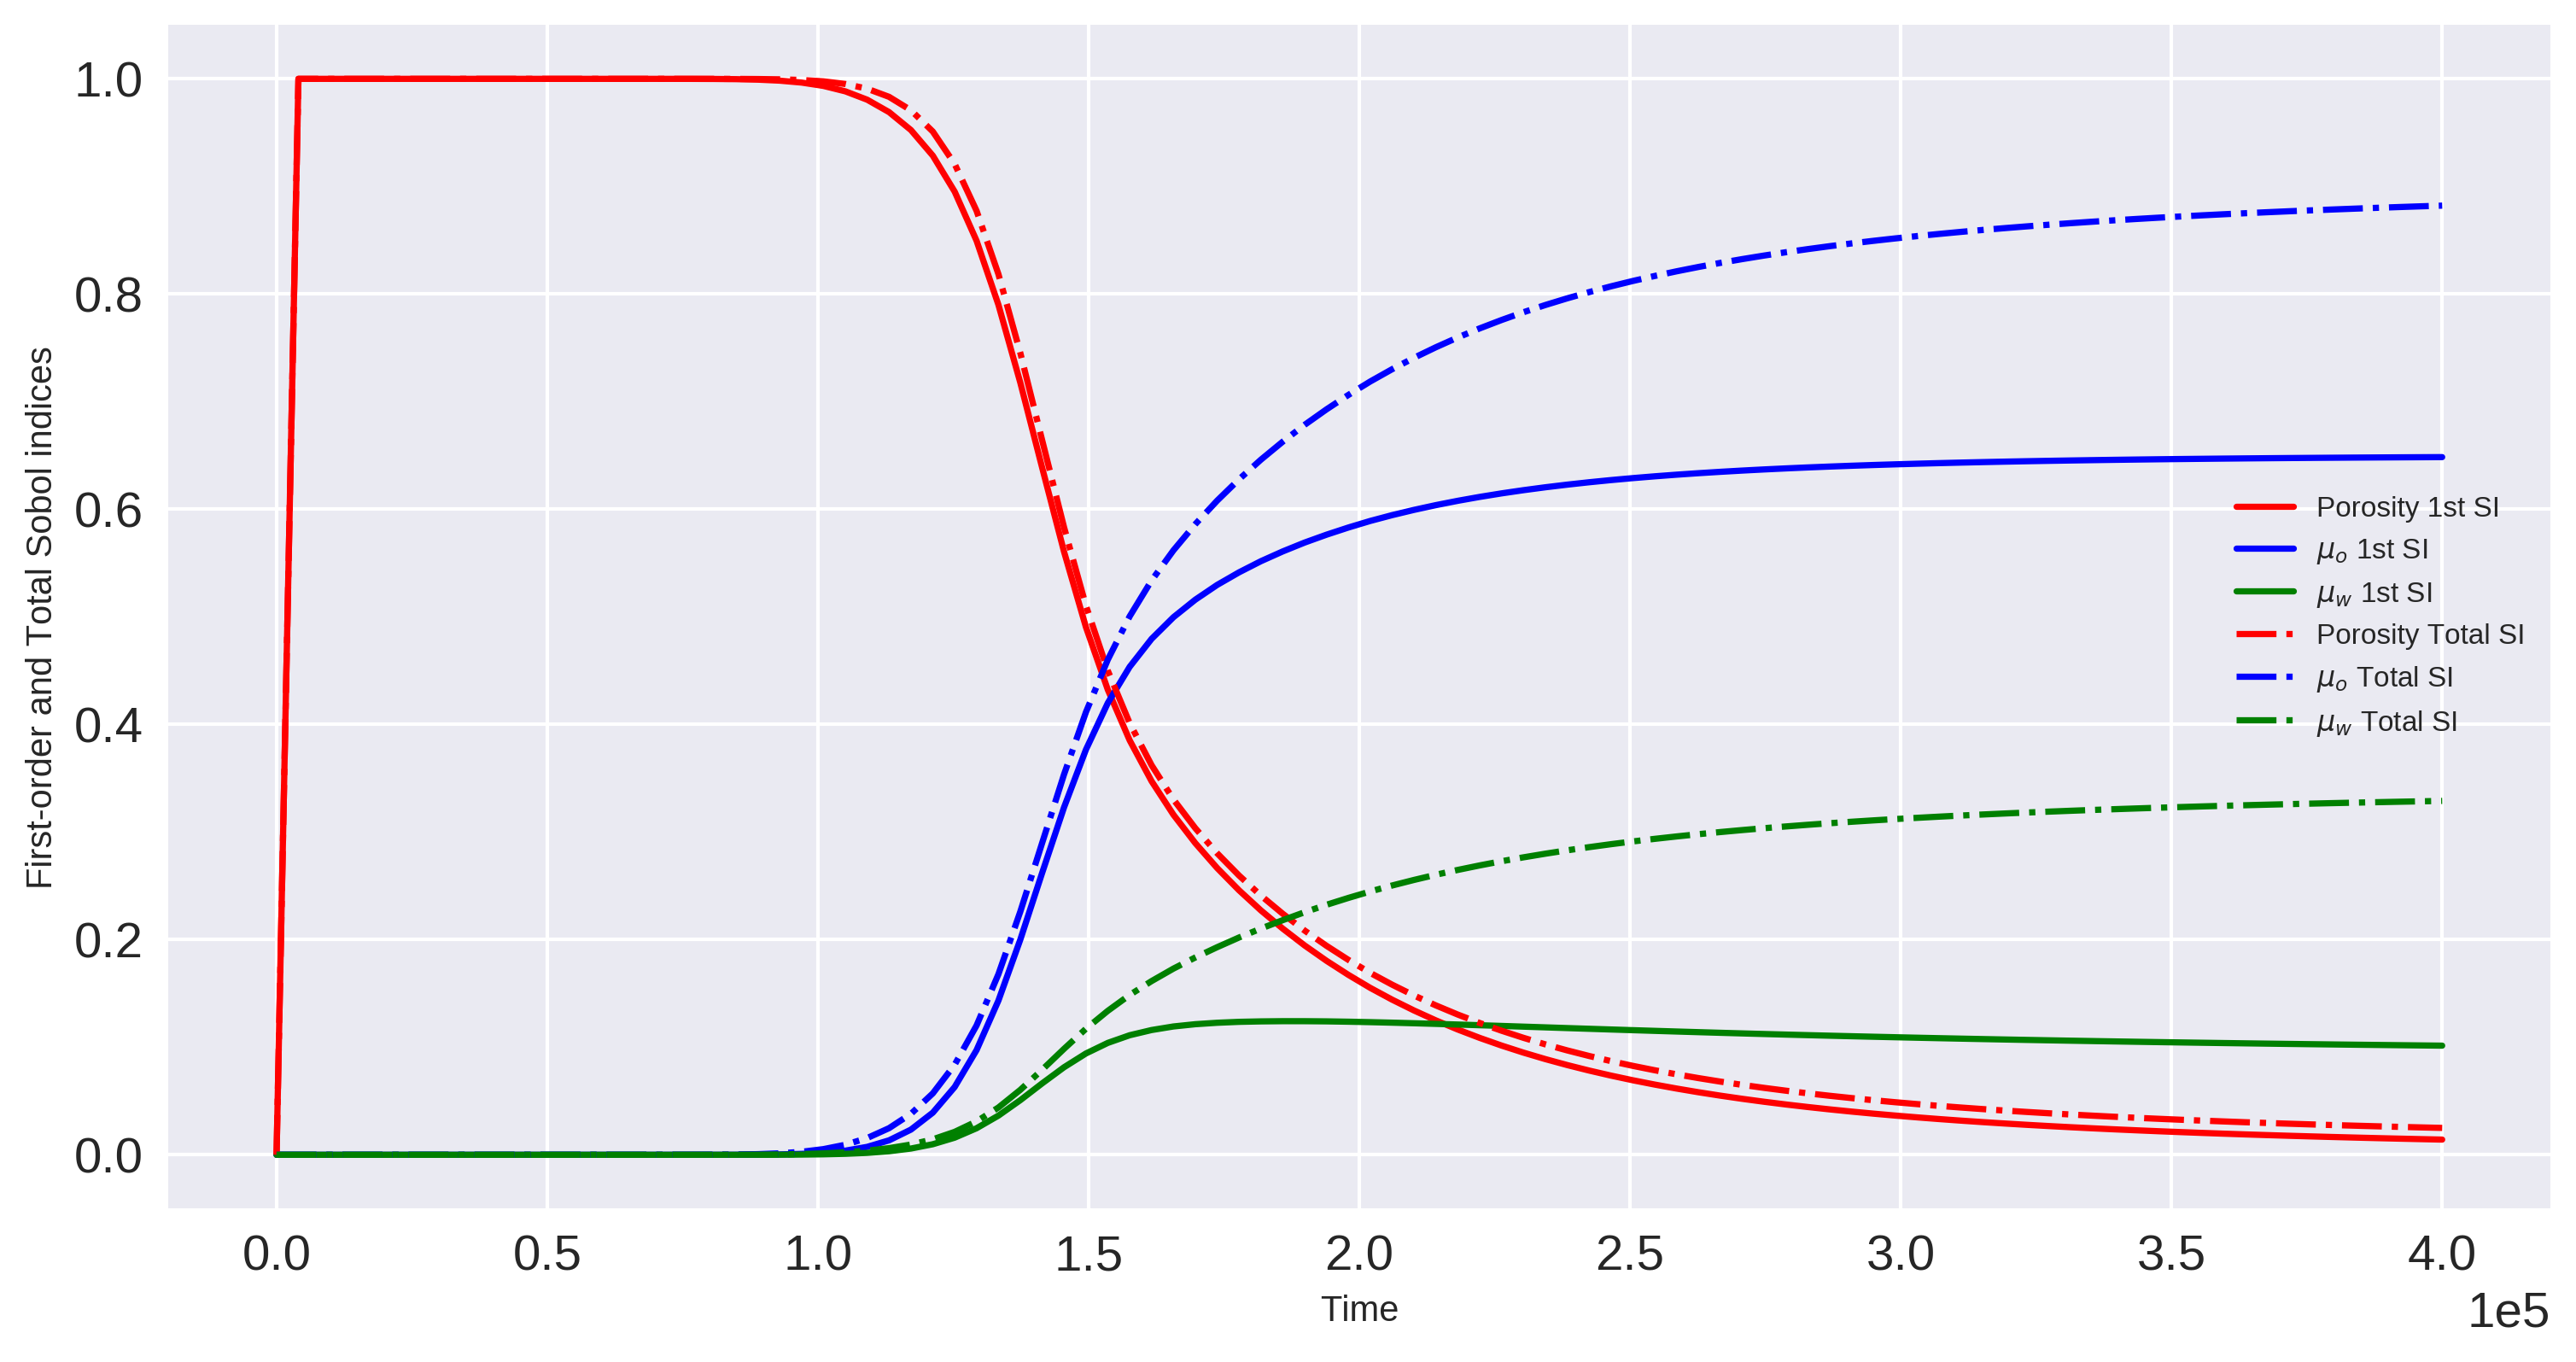

In [25]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.style.use('seaborn') 
plt.rcParams['figure.dpi'] = 300
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# upload the file that was generated and saved (otherwise it gets erased) before running this
buckley_solution = un.Data("data/pce-refined-solution.h5")
time = buckley_solution["buckley_solution"].time
mean = buckley_solution["buckley_solution"].mean
variance = buckley_solution["buckley_solution"].variance
percentile_5 = buckley_solution["buckley_solution"].percentile_5
percentile_95 = buckley_solution["buckley_solution"].percentile_95
sensitivity = buckley_solution["buckley_solution"].sobol_first
sensitivity_total = buckley_solution["buckley_solution"].sobol_total

fig1, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Pore Volumes Produced')
ax1.plot(time, mean, 'b', label='Npd')
# ax1.tick_params(axis='y', labelcolor=color)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

ax1.fill_between(time, percentile_5, percentile_95, color='lightblue')
plt.savefig('npd-uncertainpy.png')
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# color = 'tab:green'
# ax2.set_ylabel('Standard deviation', color=color)  # we already handled the x-label with ax1
# ax2.plot(time, np.sqrt(variance), color=color, label='Std')
# ax2.tick_params(axis='y', labelcolor=color)
fig1.tight_layout()  # otherwise the right y-label is slightly clipped

fig3, ax3 = plt.subplots(figsize=(12, 6))
ax3.plot(time, sensitivity[0], 'r')
ax3.plot(time, sensitivity[1], 'b')
ax3.plot(time, sensitivity[2], 'g')
ax3.plot(time, sensitivity_total[0], 'r-.')
ax3.plot(time, sensitivity_total[1], 'b-.')
ax3.plot(time, sensitivity_total[2], 'g-.')
ax3.set_xlabel('Time', fontsize=labelsize)
ax3.set_ylabel("First-order and Total Sobol indices", fontsize=labelsize)
ax3.legend(["Porosity 1st SI", r"$\mu_{o}$ 1st SI", r"$\mu_{w}$ 1st SI", "Porosity Total SI", r"$\mu_{o}$ Total SI", r"$\mu_{w}$ Total SI"], fontsize=fontsize)
plt.savefig('sobol-indices.png')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

In [ ]:
# Test running Uncertainpy with MC to check if Sobol indices are the same
folder = "data/"
filenames = []
samples = 40000
mc_data = UQ.quantify(method="mc", nr_mc_samples=samples, plot=None, save=False)
# This is to not save all model evaluations,
# otherwise the filesize would be on the order of Gb
sobol_evaluations = len(mc_data["buckley_solution"].evaluations)
mc_data["buckley_solution"].evaluations = [samples, sobol_evaluations]
filename = folder + "mc_run.h5"
mc_data.save(filename)
filenames.append(filename)



In [ ]:
# figure_width = 7.08
labelsize = 10
# titlesize = 12
fontsize = 8
# ticklabelsize = 8
# linewidth = 1
# figsize = (figure_width, figure_width*0.4)
# figure_format = ".eps"
# dpi = 300

buckley_solution = un.Data("data/mc_run.h5")
time = buckley_solution["buckley_solution"].time
mean = buckley_solution["buckley_solution"].mean
variance = buckley_solution["buckley_solution"].variance
percentile_5 = buckley_solution["buckley_solution"].percentile_5
percentile_95 = buckley_solution["buckley_solution"].percentile_95
sensitivity = buckley_solution["buckley_solution"].sobol_first
sensitivity_total = buckley_solution["buckley_solution"].sobol_total

fig1, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Pore Volumes Produced')
ax1.plot(time, mean, 'b', label='Npd')
# ax1.tick_params(axis='y', labelcolor=color)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

ax1.fill_between(time, percentile_5, percentile_95, color='lightblue')

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# color = 'tab:green'
# ax2.set_ylabel('Standard deviation', color=color)  # we already handled the x-label with ax1
# ax2.plot(time, np.sqrt(variance), color=color, label='Std')
# ax2.tick_params(axis='y', labelcolor=color)
fig1.tight_layout()  # otherwise the right y-label is slightly clipped

fig3, ax3 = plt.subplots(figsize=(12, 6))
ax3.plot(time, sensitivity[0], 'r')
ax3.plot(time, sensitivity[1], 'b')
ax3.plot(time, sensitivity[2], 'g')
ax3.plot(time, sensitivity_total[0], 'r-.')
ax3.plot(time, sensitivity_total[1], 'b-.')
ax3.plot(time, sensitivity_total[2], 'g-.')
ax3.set_xlabel('Time', fontsize=labelsize)
ax3.set_ylabel("First-order and Total Sobol indices", fontsize=labelsize)
ax3.legend(["Porosity 1st SI", r"$\mu_{o}$ 1st SI", r"$\mu_{w}$ 1st SI", "Porosity Total SI", r"$\mu_{o}$ Total SI", r"$\mu_{w}$ Total SI"], fontsize=fontsize)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

In [27]:
folder = "data/"
filenames = []#folder + "mc_run.h5"]

polynomial_orders = [2, 3, 4, 5, 6]
for polynomial_order in polynomial_orders:
    pc_data = UQ.quantify(
        polynomial_order=polynomial_order,
        plot=None,
        save=False,
        method="pc",
        pc_method="collocation",
        rosenblatt=False,
        nr_pc_mc_samples=5e4,
    )

    name = "pc_" + str(polynomial_order)
    nr_evaluations = len(pc_data["buckley_solution"].evaluations)
    pc_data["buckley_solution"].evaluations = [nr_evaluations, nr_evaluations]
    filename = folder + name + ".h5"
    pc_data.save(filename)
    filenames.append(filename)

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]
chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]
chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|██████████| 1/1 [00:09<00:00,  9.47s/it]
chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|██████████| 1/1 [00:20<00:00, 20.25s/it]
chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Calculating statistics from PCE: 100%|██████████| 1/1 [00:45<00:00, 45.32s/it]


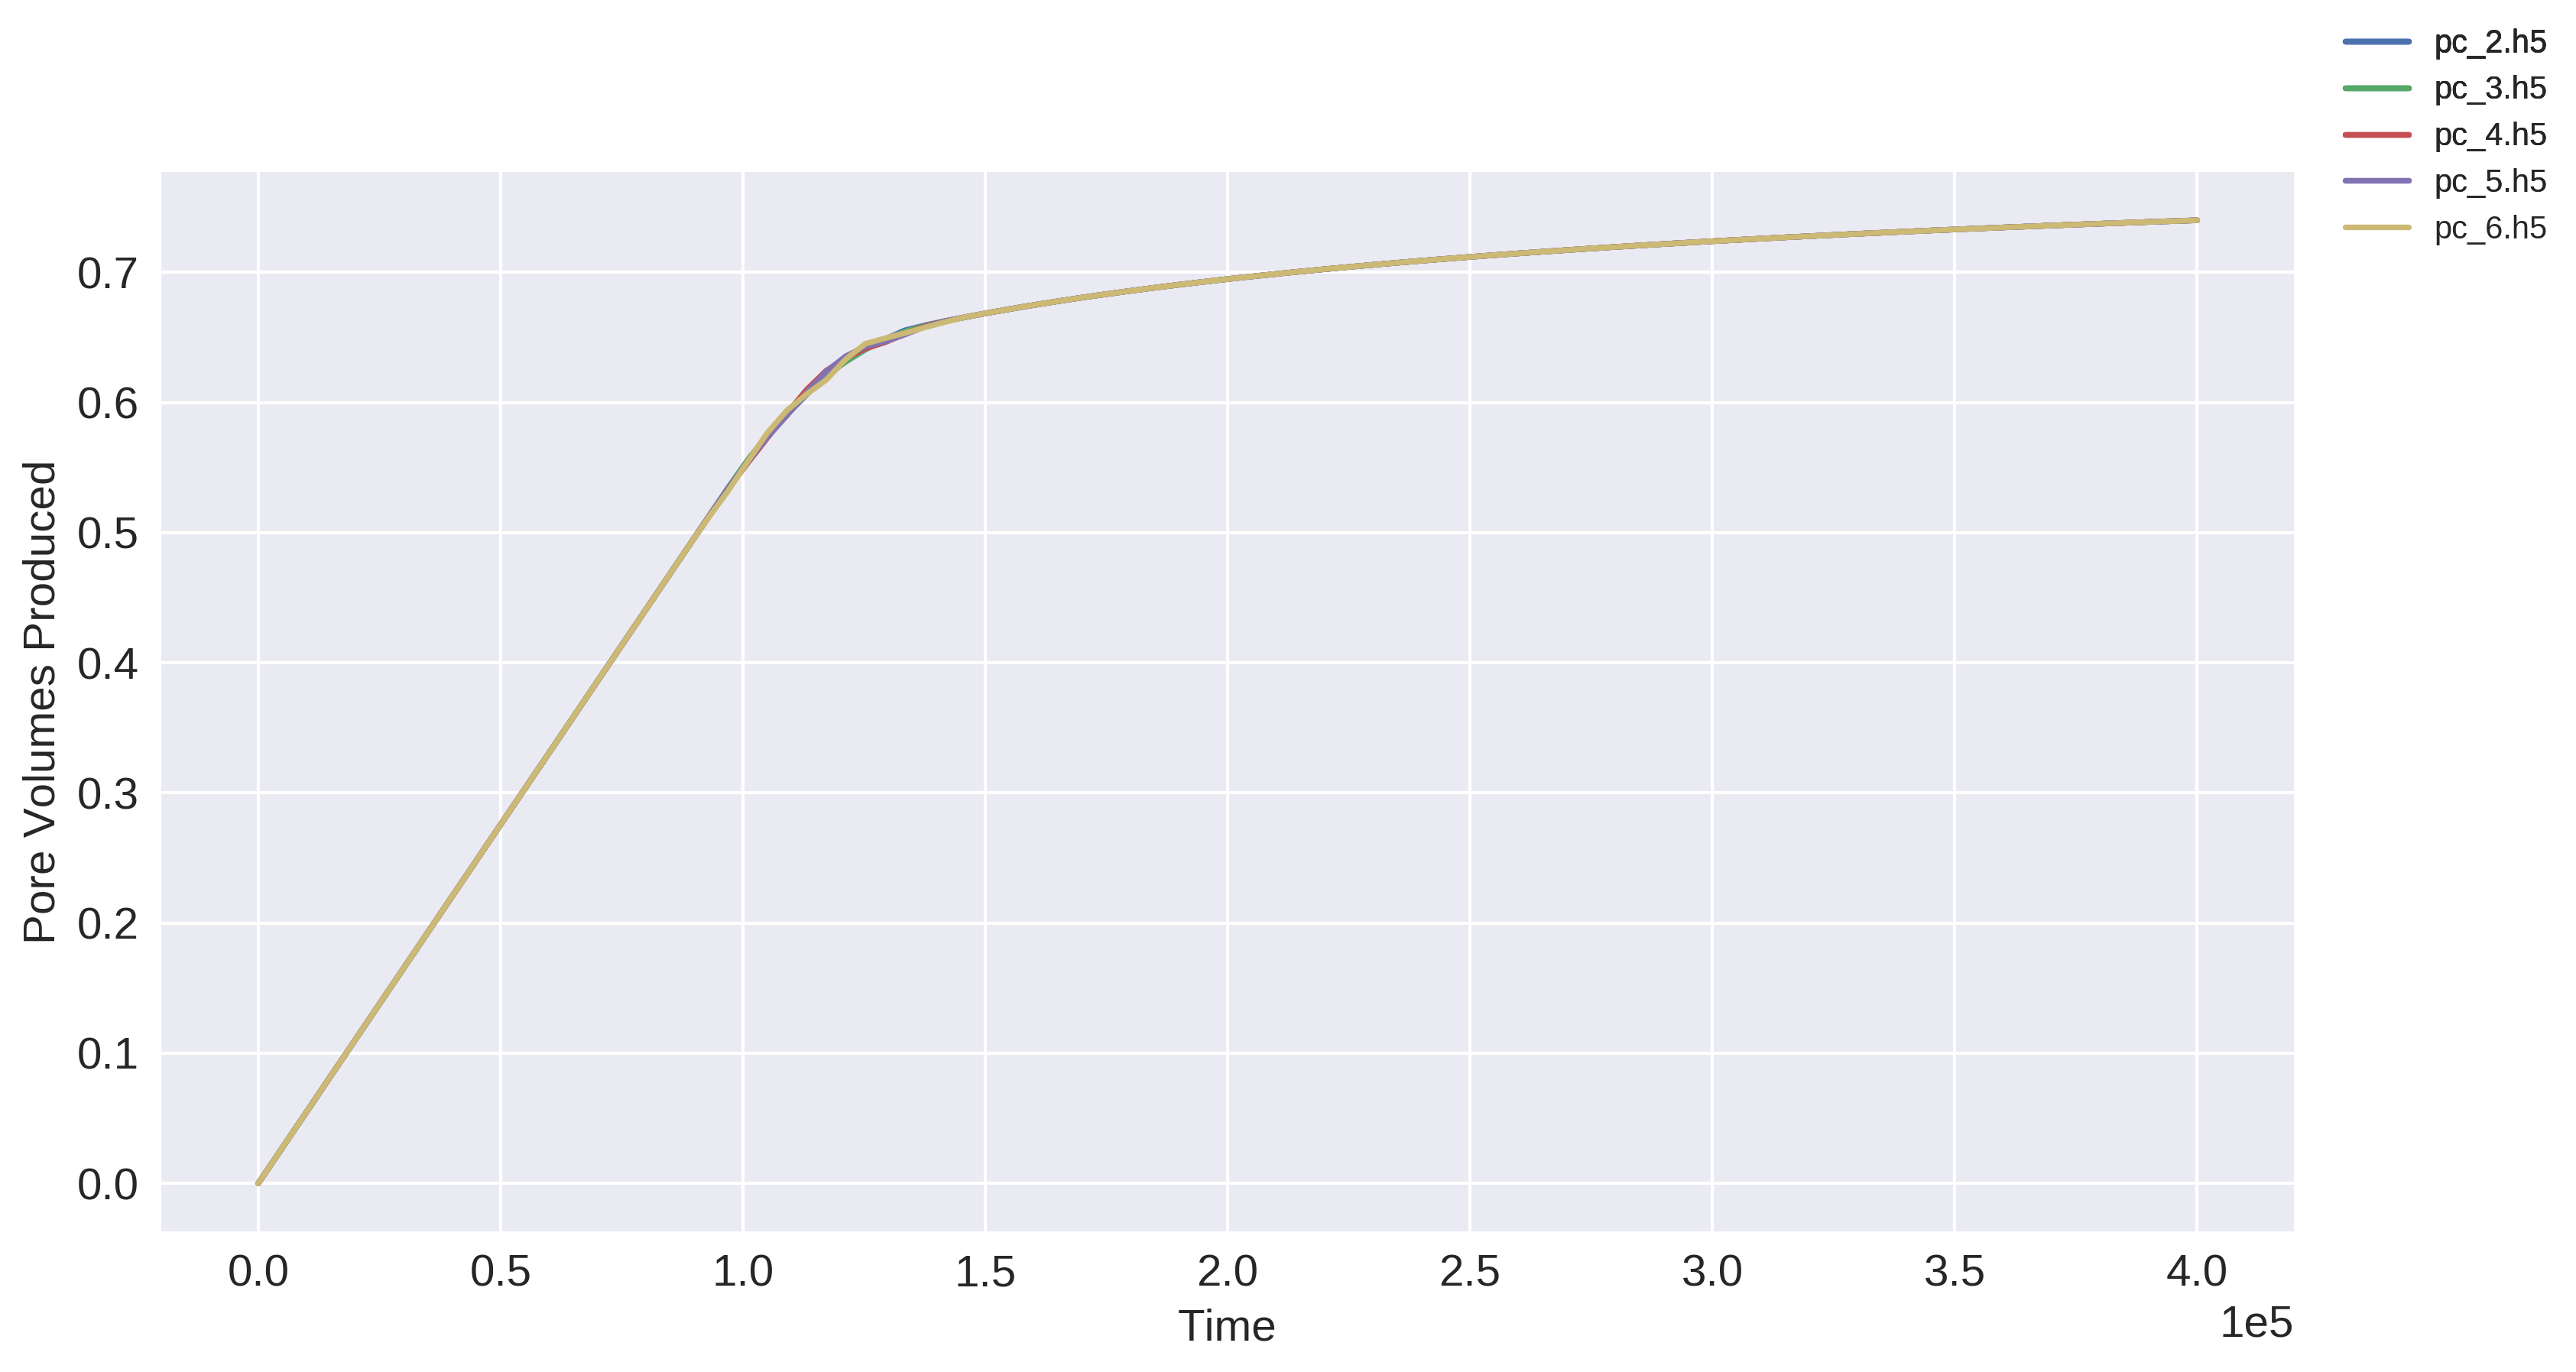

In [28]:
fig1, ax1 = plt.subplots(figsize=(12, 6))
for f in filenames:
  buckley_solution = un.Data(f)
  time = buckley_solution["buckley_solution"].time
  mean = buckley_solution["buckley_solution"].mean
  label = f.split('/')[1]
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Pore Volumes Produced')
  ax1.plot(time, mean, label=label)
  plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
  fig1.legend()

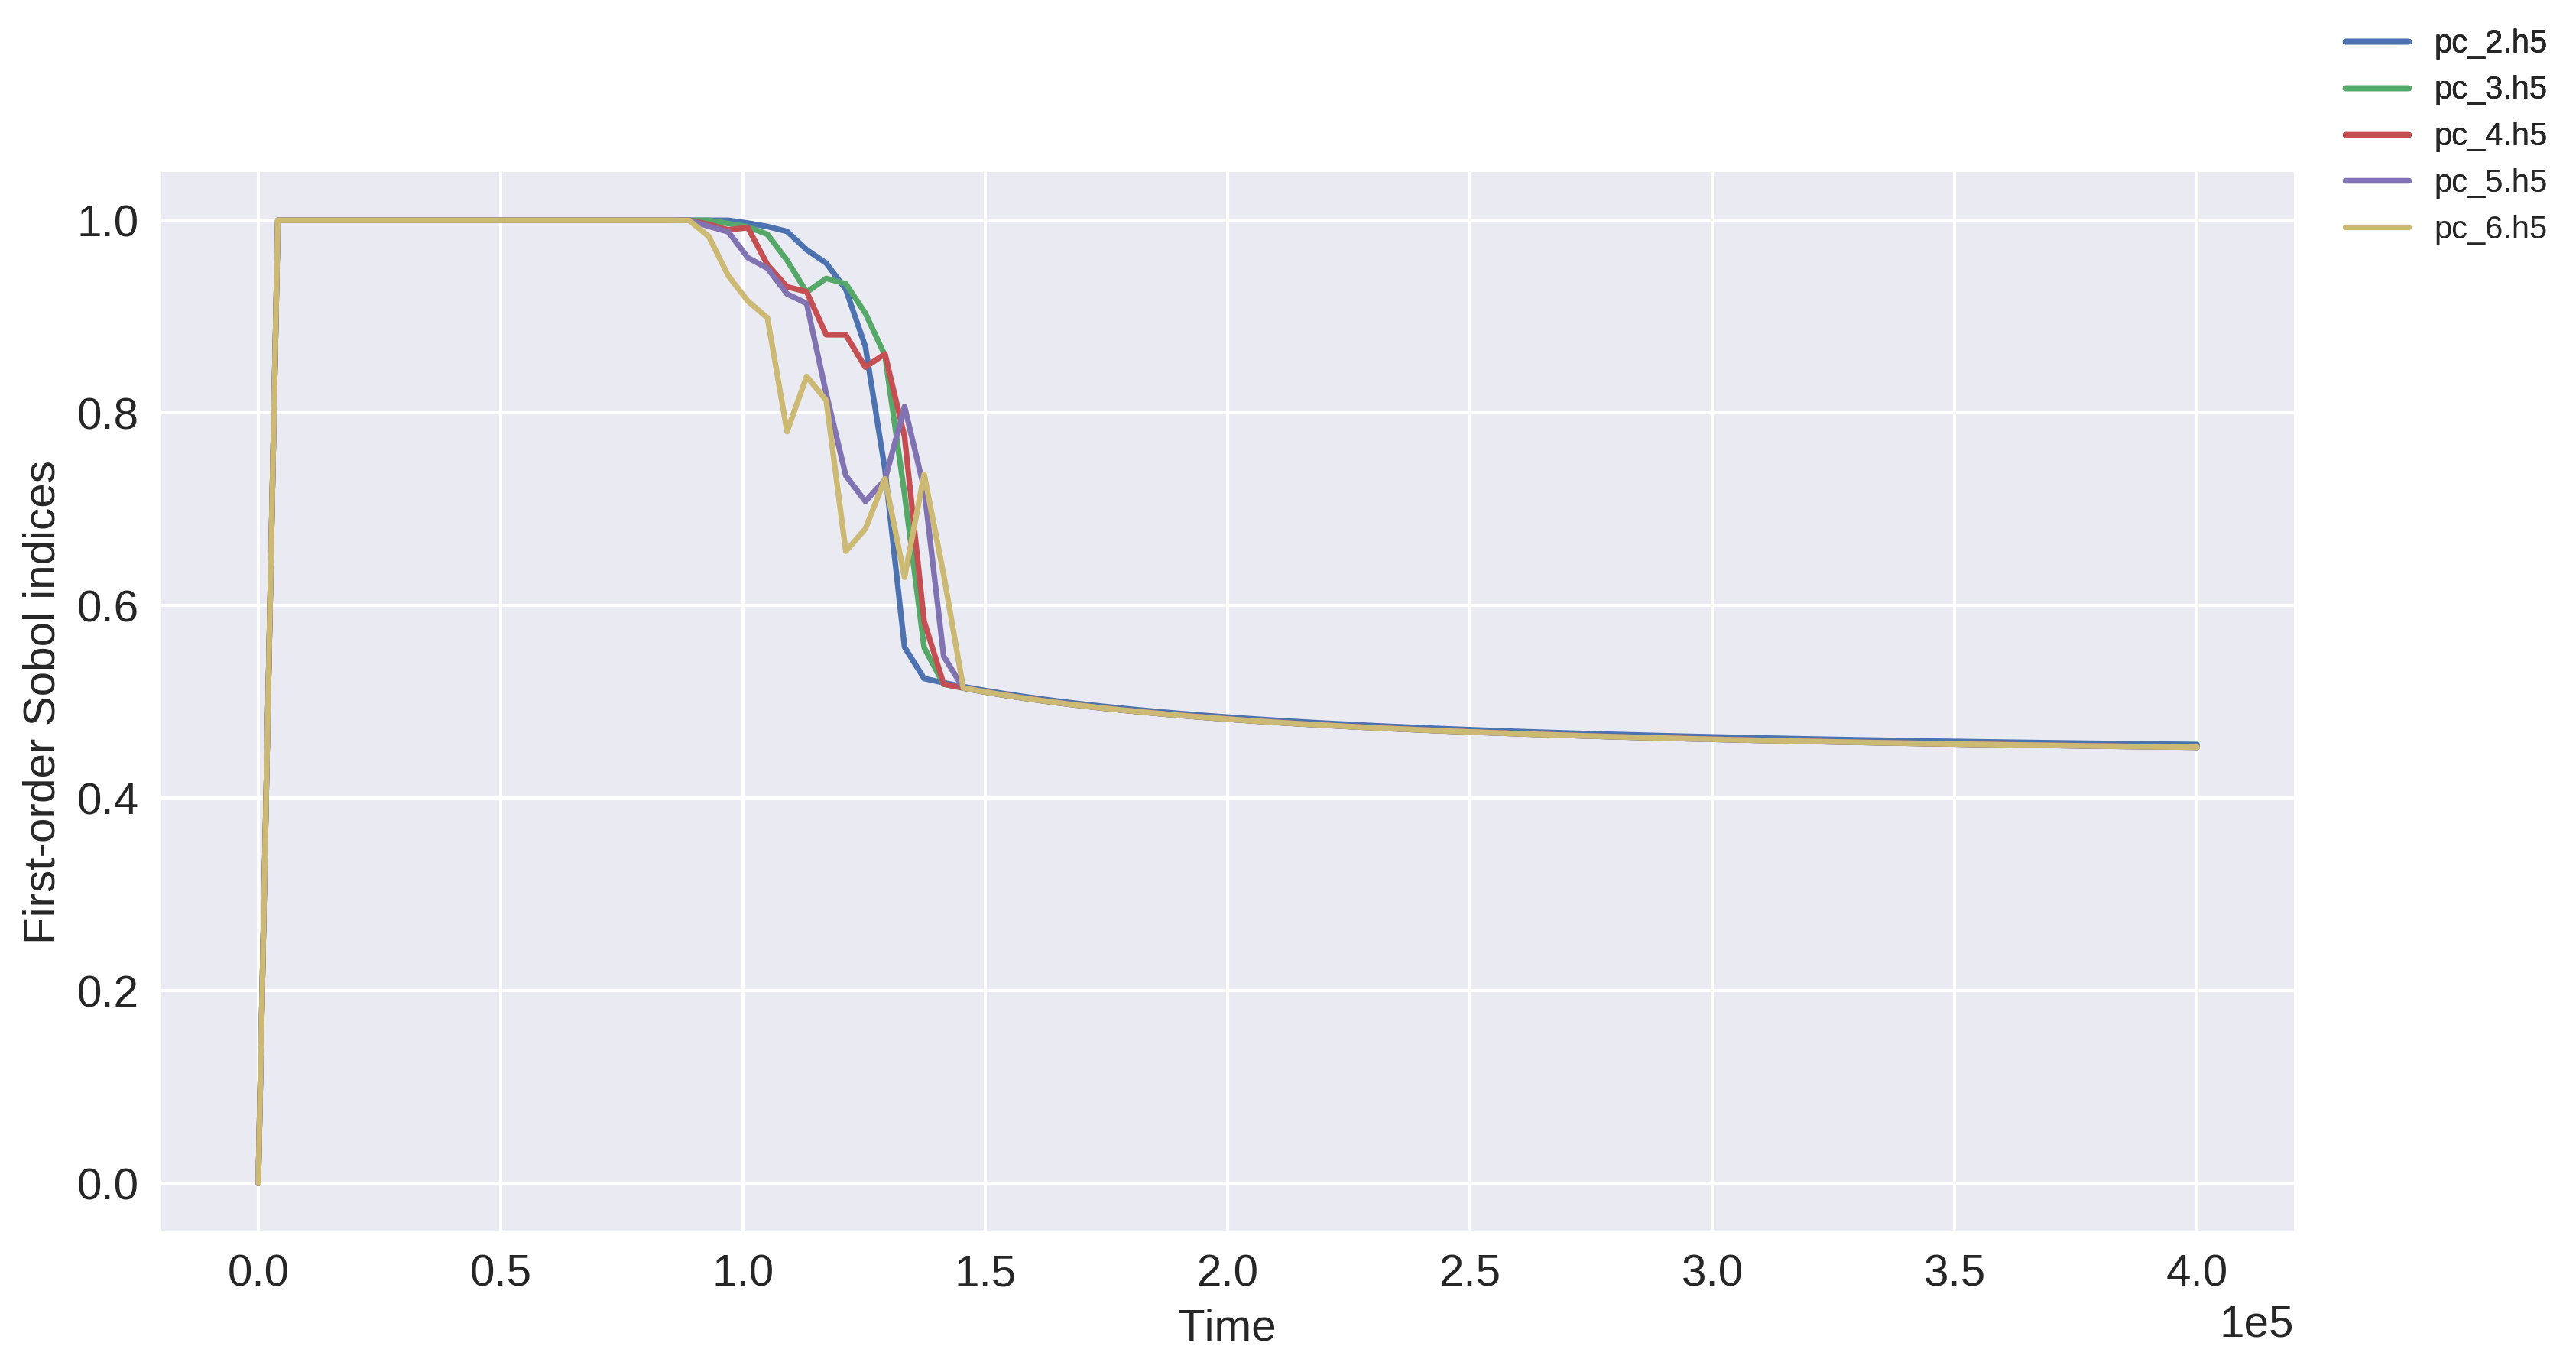

In [29]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
for f in filenames:
  buckley_solution = un.Data(f)
  time = buckley_solution["buckley_solution"].time
  sensitivity = buckley_solution["buckley_solution"].sobol_first
  sensitivity_total = buckley_solution["buckley_solution"].sobol_total
  label = f.split('/')[1]
  ax2.plot(time, sensitivity[0], label=label)


  ax2.set_xlabel('Time')
  ax2.set_ylabel("First-order Sobol indices")
  # ax2.legend(["Porosity 1st SI", r"$\mu_{o}$ 1st SI", r"$\mu_{w}$ 1st SI", "Porosity Total SI", r"$\mu_{o}$ Total SI", r"$\mu_{w}$ Total SI"], fontsize=fontsize)
  plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
  fig2.legend()